In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, sem
import seaborn as sns
import matplotlib.pyplot as plt
from biom import load_table
from scipy.stats import ttest_rel, wilcoxon, ttest_ind, spearmanr, pearsonr, t
from skbio.stats.composition import multiplicative_replacement
from ttest import paired_t_test, ttest_rel
%matplotlib inline

Let's create the second subfigure with the oral saliva experiment

In [2]:
#load metadata
metadata = pd.read_table('../data/oral_trimmed_metadata.txt', 
                         index_col=0)

#load oral samples
table = load_table('../data/oral-collapsed-table.biom').to_dataframe().T
table = table.loc[metadata.index]

# multinomial ranks
beta = pd.read_csv('../results/oral-results/differentials.csv', index_col=0)

taxonomy = pd.read_table('../data/taxonomy.tsv', index_col=0)

In [3]:
beta = pd.merge(beta, taxonomy, left_index=True, right_index=True)

In [4]:
from matplotlib.colors import rgb2hex
def plot_trajectory(ax, df, name, title='', left_title='', ypad=0, logscale=False, norm1=False):
    df = df.dropna(subset=['brushing_event'])
    subs = df['HostSubject'].value_counts().index
    for i, sub in enumerate(np.sort(subs)):
        subdf = df.loc[df['HostSubject'] == sub]
        subdf = subdf.sort_values(by='brushing_event').iloc[::-1]
        cols = sns.color_palette("husl", 10)
        x = np.arange(2)
        y = subdf.groupby('brushing_event').mean()[name][::-1]
        if norm1:
            y = y / y[0]
        else:
            y = y - y[0]

        e = subdf.groupby('brushing_event').agg(sem)[name][::-1]
        ax.errorbar(x, y, yerr=e, c='k', label=sub, marker='o')
    ax.set_xticks([0, 1])            
    ax.set_xticklabels(y.index)
    
    if logscale:
        ax.set_yscale('log')
        
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('')
    for x in ax.get_xticklabels():
        x.set_fontsize(12)
    
    ax.set_ylabel(left_title, fontsize=14, labelpad=ypad, rotation=0)

    for y in ax.get_yticklabels():
        y.set_fontsize(12)    
    #ax.legend()

In [5]:
flowcount = (metadata['flow cell 5min 1'] + metadata['flow cell 5min 2']) / 2
rmp_table = table.apply(lambda x: x * 100 / x.sum(), axis=1)
qmp_table = pd.DataFrame(table.values * flowcount.values.reshape(-1, 1),
                         index=table.index, columns=table.columns)
metadata['flowcount'] = flowcount

Look only at morning samples

In [6]:
trimmd = metadata.dropna(subset=['brushing_event'])
trimmd = trimmd[['participant-timepoint', 'brushing_event', 'flow cell 5min 1', 'flow cell 5min 2', 
                 'flowcount', 'HostSubject', 'Timepoint#']]
df = pd.melt(trimmd, id_vars = ['brushing_event', 'paricipant-timepoint', 'HostSubject', 'Timepoint#'],
             value_vars=['flow cell 5min 1', 'flow cell 5min 2'], value_name='flowcount')

df = df.loc[df['Timepoint#']<3]
meandf = df.groupby(['HostSubject', 'brushing_event']).mean()['flowcount']
df['norm_flowcount'] = df.apply(lambda x: x['flowcount'] / meandf.loc[(x['HostSubject'], 'before')], axis=1)

/Users/jmorton/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(0,0.5,'% morning microbial load')

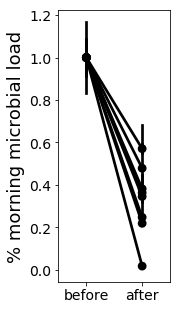

In [7]:
fig, ax = plt.subplots(figsize=(2, 5))
sns.pointplot(x='brushing_event', y='norm_flowcount', hue='HostSubject', data=df, 
              ax=ax, legend=False,
              palette={
                'C': 'k',    
                'A': 'k',    
                'I': 'k',    
                'F': 'k',   
                'E': 'k',   
                'B': 'k',   
                'H': 'k',   
                'J': 'k',  
                'G': 'k',
                'D': 'k'
              }
             )
ax.legend_.remove()

labelsize=14

ax.xaxis.set_tick_params(labelsize=labelsize)
ax.yaxis.set_tick_params(labelsize=labelsize)
ax.set_xlabel('')
ax.set_ylabel('% morning microbial load', fontsize=18)

In [8]:
actinomyces = 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces'
haemophilus = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus'

rmp_data = pd.DataFrame({
    'log(Actinomyces/Haemophilus)': np.log10(rmp_table[actinomyces]) - np.log10(rmp_table[haemophilus]),
    'Actinomyces': rmp_table[actinomyces],
    'Haemophilus': rmp_table[haemophilus],
    'brushing_event': metadata['brushing_event'],
    'HostSubject': metadata['HostSubject'],
    'Timepoint#': metadata['Timepoint#']    
})

qmp_data = pd.DataFrame({
    'log(Actinomyces/Haemophilus)': np.log10(qmp_table[actinomyces]) - np.log10(qmp_table[haemophilus]),
    'Actinomyces': qmp_table[actinomyces],
    'Haemophilus': qmp_table[haemophilus],   
    'brushing_event': metadata['brushing_event'],
    'HostSubject': metadata['HostSubject'],
    'Timepoint#': metadata['Timepoint#']    
})

/Users/jmorton/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/jmorton/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/jmorton/miniconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


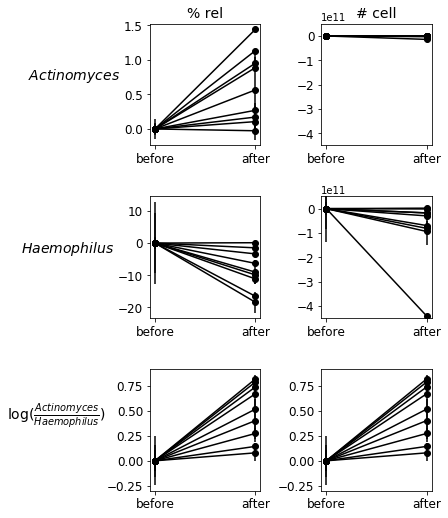

In [9]:
#fig, ax = plt.subplots()
#plot_trajectory(ax, rmp_data, name='balance')

num_taxa = 'Actinomyces'
denom_taxa = 'Haemophilus'

fig, axes = plt.subplots(3, 2, figsize=(6, 7))
plot_trajectory(axes[0][0], rmp_data, num_taxa, title='% rel',
                logscale=False, left_title=r"$\it{%s}$" % num_taxa, ypad=50)
plot_trajectory(axes[1][0], rmp_data, denom_taxa,
                logscale=False, left_title=r"$\it{%s}$" % denom_taxa, ypad=50)
plot_trajectory(axes[2][0], rmp_data, 'log(' + num_taxa + '/' + denom_taxa + ')', 
                left_title=r'$\log( \frac{' + num_taxa + '}{' + denom_taxa + '})$', ypad=50)

plot_trajectory(axes[0][1], qmp_data, num_taxa, title='# cell', logscale=False)
plot_trajectory(axes[1][1], qmp_data, denom_taxa, logscale=False)
plot_trajectory(axes[2][1], qmp_data, 'log(' + num_taxa + '/' + denom_taxa + ')')
axes[0][1].set_ylim([-4.5 * 1e11, 0.5*1e11])
axes[1][1].set_ylim([-4.5 * 1e11, 0.5*1e11])

plt.tight_layout(pad=0., w_pad=1., h_pad=2.)
plt.savefig('../figures/figure2/%s-%s.png' % (num_taxa, denom_taxa))

Test if Actinomyces is changing in the relative data

In [10]:
subrmp_data = rmp_data.dropna()
ttest_rel(np.array(subrmp_data.loc[subrmp_data['brushing_event'] == 'after', num_taxa]),
          np.array(subrmp_data.loc[subrmp_data['brushing_event'] == 'before', num_taxa]))

Ttest_relResult(statistic=3.5592251556463226, pvalue=0.0031428234969859636, lower_CI=0.1998635614494232, upper_CI=0.8059906087214438, ddof=14)

Test if Haemophilus is changing in the relative data

In [11]:
subrmp_data = rmp_data.dropna()
ttest_rel(np.array(subrmp_data.loc[subrmp_data['brushing_event'] == 'after', denom_taxa]),
          np.array(subrmp_data.loc[subrmp_data['brushing_event'] == 'before', denom_taxa]))

Ttest_relResult(statistic=-3.383111886148202, pvalue=0.0044602453097019375, lower_CI=-13.008467402513116, upper_CI=-2.914075350528009, ddof=14)

Test if Actinomyces is changing in the absolute data

In [12]:
subqmp_data = qmp_data.dropna()
ttest_rel(np.array(subqmp_data.loc[subqmp_data['brushing_event'] == 'after', num_taxa]),
          np.array(subqmp_data.loc[subqmp_data['brushing_event'] == 'before', num_taxa]))

Ttest_relResult(statistic=-1.5990036082849182, pvalue=0.13213748873932893, lower_CI=-3744732203.966374, upper_CI=545920394.2997074, ddof=14)

Test if Haemophilus is changing in the absolute data

In [13]:
subqmp_data = qmp_data.dropna()
ttest_rel(np.array(subqmp_data.loc[subqmp_data['brushing_event'] == 'after', denom_taxa]),
          np.array(subqmp_data.loc[subqmp_data['brushing_event'] == 'before', denom_taxa]))

Ttest_relResult(statistic=-2.158090526545546, pvalue=0.04877603252841402, lower_CI=-130289812258.41293, upper_CI=-402836183.9870529, ddof=14)

Test if Actinomyces:Haemophilus is changing in the relative data

In [14]:
subrmp_data = rmp_data.dropna()
ttest_rel(
    np.array(subrmp_data.loc[subrmp_data['brushing_event'] == 'after', 
                          'log(' + num_taxa + '/' + denom_taxa + ')']),
    np.array(subrmp_data.loc[subrmp_data['brushing_event'] == 'before', 
                          'log(' + num_taxa + '/' + denom_taxa + ')']))

Ttest_relResult(statistic=4.921709191905662, pvalue=0.0002249964348028542, lower_CI=0.24974036782407683, upper_CI=0.6355198165304567, ddof=14)

Test if Actinomyces:Haemophilus is changing in the absolute data

In [15]:
subqmp_data = qmp_data.dropna()
ttest_rel(np.array(subqmp_data.loc[subqmp_data['brushing_event'] == 'after', 
                          'log(' + num_taxa + '/' + denom_taxa + ')']),
          np.array(subqmp_data.loc[subqmp_data['brushing_event'] == 'before', 
                          'log(' + num_taxa + '/' + denom_taxa + ')']))

Ttest_relResult(statistic=4.921709191905658, pvalue=0.00022499643480285592, lower_CI=0.24974036782407663, upper_CI=0.6355198165304567, ddof=14)

Second panel

In [16]:
metadata['brushing_event'].value_counts()

before    15
after     15
Name: brushing_event, dtype: int64

In [17]:
raw_beta = pd.read_csv('../results/oral-results/differentials.csv', index_col=0)

Here we will compute the paired t-statistics, pvalues and confidence intervals on the deblurred data.

In [18]:
raw_table = load_table('../data/oral_deblurred.biom')
cell_table = load_table('../data/oral_deblurred.biom')

raw_df = pd.DataFrame(np.array(raw_table.matrix_data.todense()).T,
                      index=raw_table.ids(axis='sample'), 
                      columns=raw_table.ids(axis='observation'))
raw_df = raw_df.reindex(index=metadata.index, columns=raw_beta.index)

cell_df = pd.DataFrame(np.array(cell_table.matrix_data.todense()).T,
                       index=cell_table.ids(axis='sample'), 
                       columns=cell_table.ids(axis='observation'))
cell_df = cell_df.reindex(index=metadata.index, columns=raw_beta.index)
cell_df = cell_df.apply(lambda x: x * flowcount.loc[x.name], axis=1)

# Calculate paired test statistics
f = lambda x: paired_t_test(category='brushing_event', md=metadata, df=x)[0]
raw_tstats = raw_df.apply(f, axis=0)
cell_tstats = cell_df.apply(f, axis=0)

# Calculate pvalues
f = lambda x: paired_t_test(category='brushing_event', md=metadata, df=x)[1]
raw_pvalues = raw_df.apply(f, axis=0)
cell_pvalues = cell_df.apply(f, axis=0)

# Calculate lower confidence interval
f = lambda x: paired_t_test(category='brushing_event', md=metadata, df=x)[2]
raw_lower = raw_df.apply(f, axis=0)
cell_lower = cell_df.apply(f, axis=0)

# Calculate upper confidence interval
f = lambda x: paired_t_test(category='brushing_event', md=metadata, df=x)[3]
raw_upper = raw_df.apply(f, axis=0)
cell_upper = cell_df.apply(f, axis=0)

We will plot every taxa that shows
    1. differences before and after brushing teeth
    2. differences between relative and absolute abundance


We will perform the same procedure as above, but this time on the ratios.

In [19]:
subrmp_table = raw_df.loc[metadata.index]
subqmp_table = cell_df.loc[metadata.index]

In [20]:
#kname = actinomyces strain
kname = 'f58ef02fd3fe4f8f1c8ba13a3e205697'
def alr(x):
    return x / x.loc[kname]
alr_raw = raw_df.apply(alr, axis=1)
alr_cell = cell_df.apply(alr, axis=1)

In [21]:
f = lambda x: paired_t_test(category='brushing_event', md=metadata, df=x)[0]
alr_raw_tstats = alr_raw.apply(f, axis=0)
alr_cell_tstats = alr_cell.apply(f, axis=0)

f = lambda x: paired_t_test(category='brushing_event', md=metadata, df=x)[1]
alr_raw_pvalues = alr_raw.apply(f, axis=0)
alr_cell_pvalues = alr_cell.apply(f, axis=0)

/Users/jmorton/Documents/dev/reference-frames/ipynb/ttest.py:25: RuntimeWarning: invalid value encountered in double_scalars
  T = mu / se


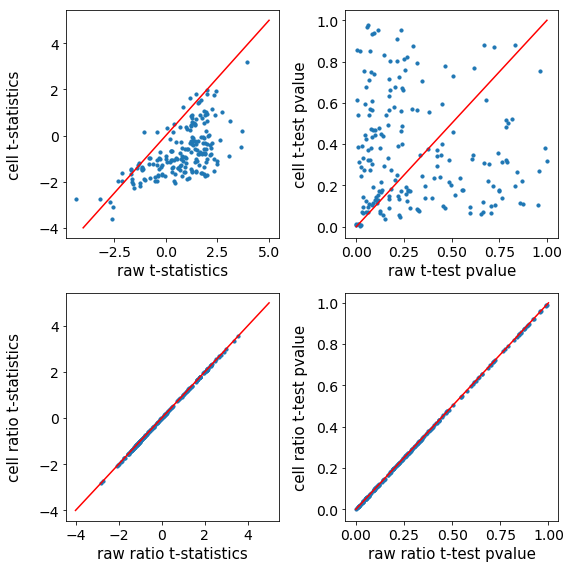

In [22]:
labelsize = 14
fontsize = 15
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0][0].scatter(raw_tstats.loc[cell_tstats.index], cell_tstats, s=10)
ax[0][0].plot(np.arange(-4, 6), np.arange(-4, 6), '-r')
ax[0][0].set_xlabel('raw t-statistics', fontsize=fontsize) 
ax[0][0].set_ylabel('cell t-statistics', fontsize=fontsize, labelpad=16)
ax[0][0].xaxis.set_tick_params(labelsize=labelsize)
ax[0][0].yaxis.set_tick_params(labelsize=labelsize)

ax[0][1].scatter(raw_pvalues.loc[cell_pvalues.index], cell_pvalues, s=10)
ax[0][1].plot(np.linspace(0, 1), np.linspace(0, 1), '-r')
ax[0][1].set_xlabel('raw t-test pvalue', fontsize=fontsize) 
ax[0][1].set_ylabel('cell t-test pvalue', fontsize=fontsize, labelpad=8)
ax[0][1].xaxis.set_tick_params(labelsize=labelsize)
ax[0][1].yaxis.set_tick_params(labelsize=labelsize)

ax[1][0].scatter(alr_raw_tstats.loc[alr_cell_tstats.index], alr_cell_tstats, s=10)
ax[1][0].plot(np.arange(-4, 6), np.arange(-4, 6), '-r')
ax[1][0].set_xlabel('raw ratio t-statistics', fontsize=fontsize) 
ax[1][0].set_ylabel('cell ratio t-statistics', fontsize=fontsize, labelpad=16)
ax[1][0].xaxis.set_tick_params(labelsize=labelsize)
ax[1][0].yaxis.set_tick_params(labelsize=labelsize)

ax[1][1].scatter(alr_raw_pvalues.loc[alr_cell_pvalues.index], alr_cell_pvalues, s=10)
ax[1][1].plot(np.linspace(0, 1), np.linspace(0, 1), '-r')
ax[1][1].set_xlabel('raw ratio t-test pvalue', fontsize=fontsize) 
ax[1][1].set_ylabel('cell ratio t-test pvalue', fontsize=fontsize, labelpad=8)
ax[1][1].xaxis.set_tick_params(labelsize=labelsize)
ax[1][1].yaxis.set_tick_params(labelsize=labelsize)

plt.tight_layout()
plt.savefig('../figures/figure2/pvals-comparison.png')

In [23]:
kf = pd.DataFrame({'raw_stats': raw_tstats.loc[cell_tstats.index], 
                   'cell_stats': cell_tstats}).dropna()
spearmanr(kf.cell_stats, kf.raw_stats)

SpearmanrResult(correlation=0.594443994885821, pvalue=5.119210241813822e-20)

In [24]:
kf = pd.DataFrame({'raw_pvals': raw_pvalues.loc[cell_pvalues.index], 
                   'cell_pvals': cell_pvalues}).dropna()
spearmanr(kf.cell_pvals, kf.raw_pvals)

SpearmanrResult(correlation=-0.021393775591124632, pvalue=0.7665725727564346)

In [25]:
kf = pd.DataFrame({'raw_stats': alr_raw_tstats.loc[alr_cell_tstats.index],
                   'cell_stats': alr_cell_tstats}).dropna()
spearmanr(kf.cell_stats, kf.raw_stats)

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)

In [26]:
kf = pd.DataFrame({'raw_pvals': alr_raw_pvalues.loc[alr_cell_pvalues.index], 
                   'cell_pvals': alr_cell_pvalues}).dropna()
spearmanr(kf.cell_pvals, kf.raw_pvals)

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)

In [27]:
#select_microbes = [actinomyces, haemophilus, prevotella, actinobacillus, porphyromonas, lautropia]
select_microbes = [actinomyces, haemophilus]
select_genera = list(map(lambda x: x.split(';')[-1], select_microbes))

In [28]:
taxa = pd.DataFrame(list(beta.Taxon.apply(lambda x: x.split(';')).values),
                    columns=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'],
                    index=beta.index)

In [29]:
taxa = taxa.fillna('None')

In [30]:
beta.head()

,Intercept,C(brushing_event)[T.before],Taxon,Confidence
99647b51f775c8ddde8ed36a7d60dbcd,4.353183,1.105140,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999981
51121722488d0c3da1388d1b117cd239,4.564780,0.797395,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.742617
d599ebe277afb0dfd4ad3c2176afc50e,3.638733,0.466282,k__Bacteria; p__Proteobacteria; c__Betaproteob...,0.796720
39c4199fe81f30a5b4b0fd5bf2f43c03,3.567794,-0.036673,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.996588
4629fbb5dde5f8ee07c2259d2887a8d4,2.803713,0.326921,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.980117


In [31]:
stats = pd.DataFrame(
    {
        'raw_tstats': cell_tstats,
        'cell_tstats': cell_tstats,
        'raw_pvalues': raw_pvalues,
        'cell_pvalues': cell_pvalues,
        'multinomial_ranks': beta["C(brushing_event)[T.before]"],
        'taxonomy': taxonomy.Taxon
    }
) 
stats = stats.reindex(
    columns=['raw_tstats', 'cell_tstats', 'raw_pvalues', 
             'cell_pvalues', 'multinomial_ranks', 'taxonomy'])
stats.to_csv('../figures/Table_S1.csv') 

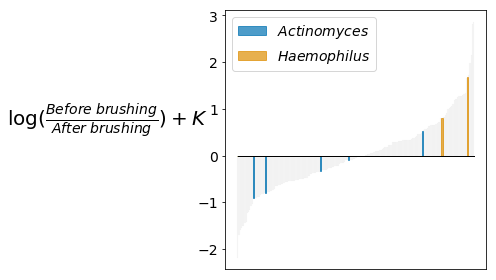

In [32]:
# plot all of the ranks
coefs = beta["C(brushing_event)[T.before]"].sort_values()
taxa = taxa.reindex(index=coefs.index)
genera = taxa.Genus.values
genera = np.array(list(map(lambda x: x.lstrip(), genera)))

x = np.arange(coefs.shape[0])
fig = plt.figure(figsize=(7, 4))
plt.bar(x, coefs, 1, label='', alpha=0.2, edgecolor='#D0D0D0', lw=0.1, color='#D0D0D0') #gray
plt.xlabel('species')
plt.xticks([])
plt.ylabel(r'$\log (\frac{Before \; brushing}{After \; brushing}) + K$', fontsize=20, labelpad=90, rotation=0)

genus_colors = dict(zip(select_genera, sns.color_palette("colorblind", len(select_genera))))

for genus in select_genera:
    
    filtered_beta = pd.Series(index=coefs.index).fillna(0)
    select_genus = genera == genus
    filtered_beta[select_genus] = coefs[select_genus]

    plt.bar(x, filtered_beta.values, 1, label="$\it{%s}$" % genus[3:], 
            alpha=0.7, edgecolor=genus_colors[genus], 
            facecolor=genus_colors[genus], lw=1)
    
plt.xlabel('')    
plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot(x, np.array([0]*len(x)), c='k', lw=1)

plt.legend(fontsize=14)
plt.tight_layout()
fig.savefig('../figures/figure2/saliva-ranks.png')

Let's run a test on the flow cytometry data, just to make sure that the total microbial load decreased.

In [33]:
metadata['flowcount'] = flowcount
submetadata = metadata[['brushing_event', 'flowcount']].dropna()
b = submetadata['brushing_event'] == 'before'
a = submetadata['brushing_event'] == 'after'
ttest_rel(submetadata.loc[b, 'flowcount'].values,
          submetadata.loc[a, 'flowcount'].values)

Ttest_relResult(statistic=2.172093745500906, pvalue=0.0475178804078482, lower_CI=180871.35474433564, upper_CI=28593341.11192233, ddof=14)

We'll save the statistical tests for the raw vs cell normalized in a separate file

In [34]:
pvals = pd.DataFrame(
    {
        'raw_lower_CI': raw_lower.loc[cell_lower.index], 
        'cell_lower_CI': cell_lower,
        'raw_upper_CI': raw_upper.loc[cell_upper.index], 
        'cell_upper_CI': cell_upper,        
        'raw_pvals': raw_pvalues.loc[cell_pvalues.index], 
        'cell_pvals': cell_pvalues,
        'raw_tstats': raw_tstats.loc[cell_tstats.index], 
        'cell_tstats': cell_tstats,        
        'ranks': raw_beta['C(brushing_event)[T.before]']
    },
    index=cell_pvalues.index
)
pvals = pd.merge(pvals, taxonomy, left_index=True, right_index=True)
pvals.sort_values(by='cell_pvals').to_csv('../figures/Table_S2.csv')

ANCOM2 and ALDEx2 comparison

In [35]:
# load up results from ANCOM and ALDEx2
aldex2_res = pd.read_table('../results/oral-results/aldex2_results.txt', 
                           sep=' ', index_col=0)
aldex2_res = aldex2_res.set_index('sfit.category') 

ancom_res = pd.read_csv('../results/oral-results/ancom_results_mixed.csv', index_col=0)
ancom_res['W_stat'] = ancom_res['W_stat'].fillna(0)
ancom_res['detected_0.9'] = ancom_res['detected_0.9'].fillna(False)
ancom_res['detected_0.8'] = ancom_res['detected_0.8'].fillna(False)
ancom_res['detected_0.7'] = ancom_res['detected_0.7'].fillna(False)
ancom_res['detected_0.6'] = ancom_res['detected_0.6'].fillna(False)

# correct the indexes in aldex2
def rename_f(x):
    if x[0] == 'X':
        return x[1:]
    else:
        return x
aldex2_res.index = list(map(lambda x: rename_f(x), aldex2_res.index))
ancom_res.index = list(map(lambda x: rename_f(x), ancom_res.index))

In [36]:
# sort the differentials obtained from songbird, and sort ALDEx2 and ANCOM relative to that.
songbird_res = beta.sort_values(by='C(brushing_event)[T.before]')
ancom_res = ancom_res.reindex(index=songbird_res.index)
aldex2_res = aldex2_res.reindex(index=songbird_res.index)

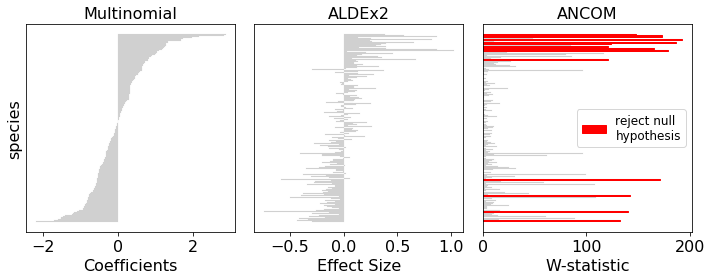

In [37]:
fontsize = 16

coefs = songbird_res.sort_values('C(brushing_event)[T.before]')['C(brushing_event)[T.before]']
idx = coefs.index

x = np.arange(idx.shape[0])
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

x = np.arange(idx.shape[0])
ax[0].barh(x, coefs, 1, label='', edgecolor='#D0D0D0', lw=0.1, color='#D0D0D0') #gray
ax[0].set_ylabel('species', fontsize=fontsize)
ax[0].set_yticks([])
ax[0].set_xlabel('Coefficients', fontsize=fontsize)
ax[0].set_title('Multinomial', fontsize=fontsize)
ax[0].xaxis.set_tick_params(labelsize=fontsize)

aldex2_res = aldex2_res.reindex(index=idx)
coefs = aldex2_res['sfit.effect']
aldex2_sig = aldex2_res['sfit.padj'] < 0.05
ax[1].barh(x, coefs, 1, label='', edgecolor='#D0D0D0', lw=0.1, color='#D0D0D0') #gray
j = coefs.index[aldex2_sig]
k = [coefs.index.get_loc(u) for u in j]
aldex2_sig = aldex2_sig.index[aldex2_sig]
ax[1].barh(k, coefs.loc[j], 1, 
           label='reject null \nhypothesis', edgecolor='#ff0000', lw=1, color='r') #red
ax[1].set_yticks([])
ax[1].set_xlabel('Effect Size', fontsize=fontsize)
ax[1].set_title('ALDEx2', fontsize=fontsize)
ax[1].xaxis.set_tick_params(labelsize=fontsize)

ancom_sig = ancom_res['detected_0.6']
coefs = ancom_res['W_stat']
ax[2].barh(x, coefs, 1, label='', edgecolor='#D0D0D0', lw=0.1, color='#D0D0D0') #gray
ax[2].set_yticks([])
ax[2].set_xlabel('W-statistic', fontsize=fontsize)
ax[2].set_title('ANCOM', fontsize=fontsize)
j = coefs.index[ancom_sig]
k = [coefs.index.get_loc(u) for u in j]
ancom_sig = ancom_sig.index[ancom_sig]
ax[2].barh(k, coefs.loc[j], 1, 
           label='reject null \nhypothesis', edgecolor='#ff0000', lw=1, color='r') #red

ax[2].xaxis.set_tick_params(labelsize=fontsize)

ax[2].legend(fontsize=12)
plt.tight_layout()
plt.savefig('../figures/figure2/oral_comparision.png')

In [38]:
# pull out ancom most negative hit
veillonella = ancom_res.loc[ancom_res['detected_0.6']].index[0]

In [39]:
pvals.loc['2be90cc9bd2811af7cca6bc28463b176']

raw_lower_CI                                               9.65024
cell_lower_CI                                         -3.69757e+08
raw_upper_CI                                               83.2831
cell_upper_CI                                          1.06754e+09
raw_pvals                                                0.0170226
cell_pvals                                                0.315407
raw_tstats                                                 2.70697
cell_tstats                                                1.04125
ranks                                                      -1.7057
Taxon            k__Bacteria; p__Firmicutes; c__Clostridia; o__...
Confidence                                                 0.93212
Name: 2be90cc9bd2811af7cca6bc28463b176, dtype: object